In [2]:
import sys
import os.path as osp
import requests
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
from scipy.stats import norm 
import scipy.stats as st
import pandas as pd
import pymc3 as pm
import arviz as az
from sklearn.metrics import mean_absolute_error
import pandas as pd
import seaborn as sns

SRC_SUBDIR = '../'
SRC_SUBDIR = osp.abspath(SRC_SUBDIR)
if SRC_SUBDIR not in sys.path:
    print(f'Adding source directory to the sys.path: {SRC_SUBDIR!r}')
    sys.path.insert(1, SRC_SUBDIR)

palette = ['#001A72', '#FC4C02', '#41B6E6', '#B7C01B', '#00D4C5', '#00A499', '#DBE442']
bg = '#EBF6F3'

plt.rcParams.update({'axes.facecolor':bg})
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=palette)

Adding source directory to the sys.path: '/home/lsio/projects'


In [28]:
# beta_age = [1, .5, .3, .2, .1, .05, .03, .02, .01, .01]
# beta_period = .1
# beta_cohort = .05
beta_0 = -3

In [83]:
np.random.choice([0, 1], size = 100000)

array([0, 0, 0, ..., 0, 0, 1])

In [86]:
# test_yob = pd.DataFrame({"age":np.random.choice(range(10), size = 100000)})
test_yob = pd.DataFrame({"age":np.random.choice([0, 1], size = 100000)})
test_yob["age"] = test_yob["age"].astype(int)
test_yob["default_proba"] = 1/(1 + np.exp(-(test_yob["age"]*0.5 + beta_0))).values
test_yob["default"] = np.random.binomial(1, test_yob.default_proba)

In [87]:
apc_df = (test_yob.groupby(["age"])
            ["default"]
            .agg(("size", "sum")))

In [88]:
N = apc_df["size"].values
defaults = apc_df["sum"].values

i, age_map = apc_df.index.get_level_values("age").factorize(sort=True)

coords = {
    "age": age_map
}

In [109]:
i

array([0, 1])

In [89]:
# the scale necessary to make a halfnormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

In [90]:
uk_unemp = pd.read_csv("./data/uk_quart_unemp.csv")

In [91]:
df = uk_unemp.copy()
period = uk_unemp.unemp.values
cohort = (np.random.normal(0, 3, size = len(period)) + period)*.05
df["market_effect"] = cohort
df["economic_stress"] = period*0.1
df["originations"] = 1000
df = df.set_index("year")
df = df[df.index > 1990]

In [92]:
CHAINS = 6
SEED = 1234567890 # for reproducibility
SAMPLE_KWARGS = {
    "cores": CHAINS,
    "random_seed": [SEED + i for i in range(CHAINS)]
}

In [119]:
# def noncentered_normal(name, *, dims):
#     offset = pm.Normal(f"offset_{name}", 0, 1, dims=dims)
#     Δ = pm.Normal(f"Δ_{name}", 0, 1, dims=dims)
#     σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)
    
#     return pm.Deterministic(name, Δ * σ + offset, dims=dims)

with pm.Model(coords=coords) as nc_model:
    η0 = pm.Normal("η0", 0, 3)

    # α = noncentered_normal("α", dims="age")
    # β = noncentered_normal("β", dims="period")
    # γ = noncentered_normal("γ", dims="cohort")
    α = pm.Normal("α", 0, 2, dims="age")
    # α = pm.Normal("α", 0, 2)

In [120]:
with nc_model:
    η = η0 + α[i]
    
    p = pm.math.invlogit(η)
    pm.Binomial("default", N, p, observed=defaults)

with nc_model:
    nc_trace = pm.sample(target_accept=0.9, **SAMPLE_KWARGS)

/home/lsio/.cache/pypoetry/virtualenvs/notebooks-5GmdqOuk-py3.10/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [α, η0]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 25 seconds.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/lsio/.cache/pypoetry/virtualenvs/notebooks-5GmdqOuk-py3.10/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


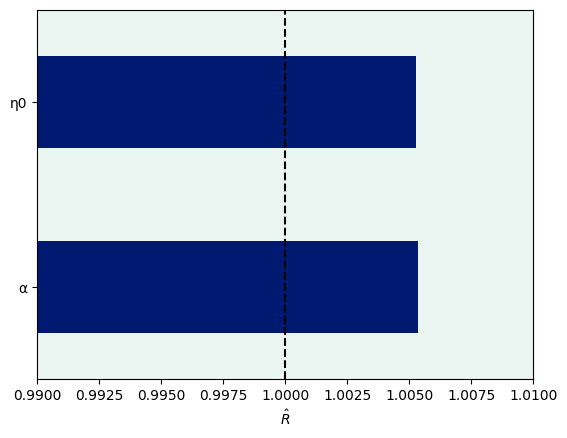

In [121]:
nc_rhat = az.rhat(nc_trace)

ax = (nc_rhat.max()
             .to_array()
             .to_series()
             .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.01);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

In [122]:
nc_trace["η0"].mean()

-2.317687375185243

In [125]:
nc_trace["α"].mean(axis = 0)

array([-0.68711437, -0.20038507])

In [123]:
nc_trace["α"].mean()

-0.44374972185536393

In [101]:
nc_trace["α"].mean(axis = 0)

array([-0.68711437, -0.20038507])

<Axes: >

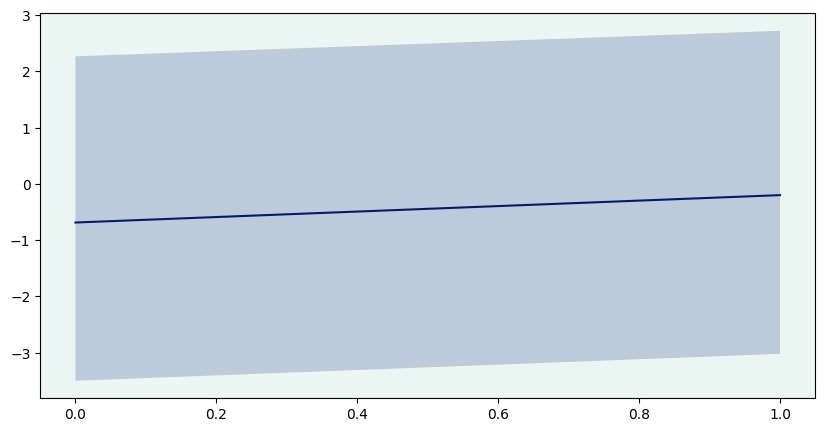

In [98]:
_, ax  = plt.subplots(figsize = (10, 5))
ax.fill_between(
    coords["age"], 
    pd.DataFrame(nc_trace["α"]).quantile(.01, axis = 0),
    pd.DataFrame(nc_trace["α"]).quantile(.99, axis = 0),
    alpha = 0.2
)
pd.Series(nc_trace["α"].mean(axis = 0)).plot(ax = ax)
# pd.Series(beta_age).plot(ax = ax)

In [35]:
loan_term = 10
book_age = {}
defaults = []
reimbursed = []
years_on_book = []
loan_id = 0
for y in df.index.unique():
    for i in range(df.loc[y, "originations"]):
        book_age[loan_id] = 0
        loan_id += 1


    active_loans = [k for k in book_age.keys()]
    for k in active_loans:
        period = df.loc[y, "economic_stress"]
        age = book_age[k]
        cohort = df.loc[y - age, "market_effect"]
        # default_proba = 1/(1 + np.exp(-(beta_0 + beta_period*period + beta_cohort*cohort + beta_age[age])))
        default_proba = 1/(1 + np.exp(-(beta_0 + beta_age[age])))
        # default_proba = 1/(1 + np.exp(-(beta_0)))
        default = np.random.binomial(1, default_proba)
        if default:
            defaulted_loan = {"loan_id":k, "age":book_age.pop(k), "year":y, "default":1}
            defaults.append(defaulted_loan)
            years_on_book.append(defaulted_loan)
        else:
            years_on_book.append( {"loan_id":k, "age":book_age[k], "year":y, "default":0})
            book_age[k] += 1
            if book_age[k] == loan_term:
                # print(f"reimb {y}")
                reimbursed.append({"loan_id":k, "age":book_age.pop(k), "year":y})

In [36]:
yob = pd.DataFrame(years_on_book)
yob["period"] = yob["year"]
yob["cohort"] = yob["year"] - yob["age"]
yob.drop("year", axis = 1, inplace = True)
yob.head()

,loan_id,age,default,period,cohort
0,0,0,0,1991,1991
1,1,0,0,1991,1991
2,2,0,0,1991,1991
3,3,0,0,1991,1991
4,4,0,0,1991,1991


<Axes: xlabel='age'>

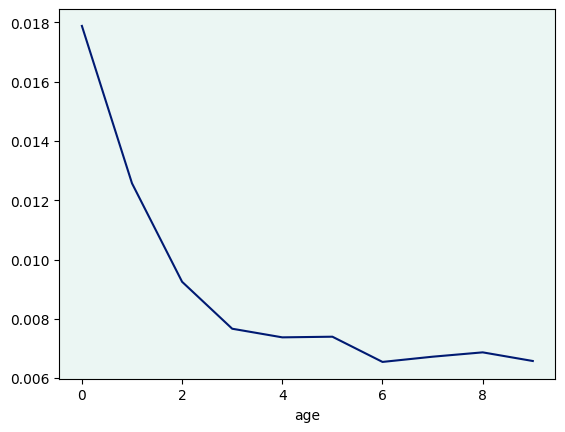

In [58]:
t = yob.groupby(["age"])["default"].agg(("size", "sum"))
(t["sum"]/t["size"]).plot()

In [37]:
apc_df = (yob.groupby(["age", "period", "cohort"])
            ["default"]
            .agg(("size", "sum")))

In [39]:
N = apc_df["size"].values
defaults = apc_df["sum"].values

i, age_map = apc_df.index.get_level_values("age").factorize(sort=True)
j, period_map = apc_df.index.get_level_values("period").factorize(sort=True)
k, cohort_map = apc_df.index.get_level_values("cohort").factorize(sort=True)

coords = {
    "age": age_map,
    "period": period_map,
    "cohort": cohort_map
}

In [42]:
CHAINS = 6
SEED = 1234567890 # for reproducibility
SAMPLE_KWARGS = {
    "cores": CHAINS,
    "random_seed": [SEED + i for i in range(CHAINS)]
}

In [43]:
# the scale necessary to make a halfnormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

In [45]:
def noncentered_normal(name, *, dims):
    offset = pm.Normal(f"offset_{name}", 0, 1, dims=dims)
    Δ = pm.Normal(f"Δ_{name}", 0, 1, dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)
    
    return pm.Deterministic(name, Δ * σ + offset, dims=dims)

with pm.Model(coords=coords) as nc_model:
    η0 = pm.Normal("η0", 0, 3)

    α = noncentered_normal("α", dims="age")
    # β = noncentered_normal("β", dims="period")
    # γ = noncentered_normal("γ", dims="cohort")
    # α = pm.Normal("α", 0, 1, dims="age")

In [46]:
with nc_model:
    η = η0 + α[i]
    
    p = pm.math.invlogit(η)
    pm.Binomial("default", N, p, observed=defaults)

with nc_model:
    nc_trace = pm.sample(target_accept=0.9, **SAMPLE_KWARGS)

/home/lsio/.cache/pypoetry/virtualenvs/notebooks-5GmdqOuk-py3.10/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [σ_α, Δ_α, offset_α, η0]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 38 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [48]:
nc_trace["η0"].mean()

-4.7081125582708

<Axes: >

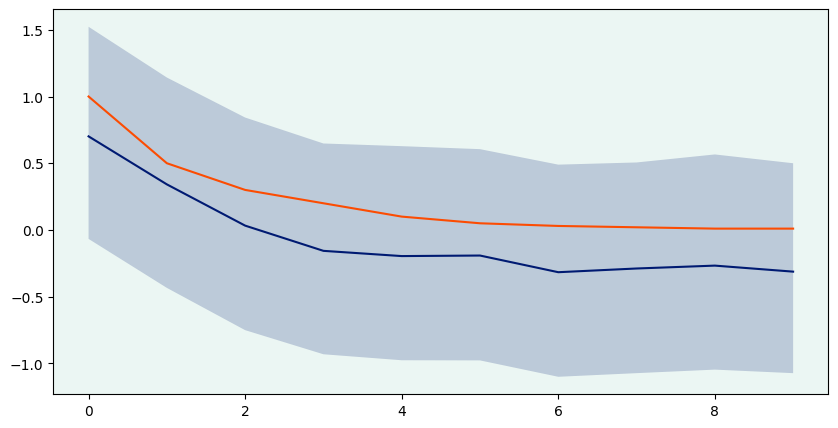

In [49]:
_, ax  = plt.subplots(figsize = (10, 5))
ax.fill_between(
    coords["age"], 
    pd.DataFrame(nc_trace["α"]).quantile(.01, axis = 0),
    pd.DataFrame(nc_trace["α"]).quantile(.99, axis = 0),
    alpha = 0.2
)
pd.Series(nc_trace["α"].mean(axis = 0)).plot(ax = ax)
pd.Series(beta_age).plot(ax = ax)

<Axes: >

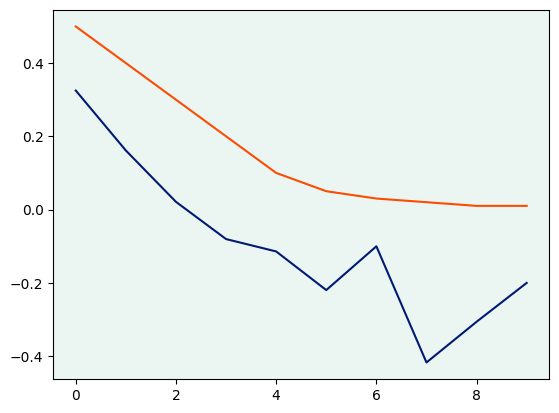

In [19]:
pd.Series(nc_trace["α"].mean(axis = 0)).plot()
pd.Series(beta_age).plot()

In [80]:
nc_trace["η0"].mean()

-4.986435361946871

Got error No model on context stack. trying to find log_likelihood in translation.
/home/lsio/.cache/pypoetry/virtualenvs/notebooks-5GmdqOuk-py3.10/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


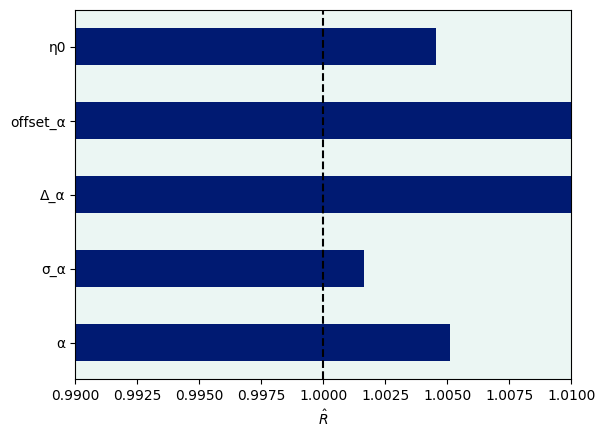

In [32]:
nc_rhat = az.rhat(nc_trace)

ax = (nc_rhat.max()
             .to_array()
             .to_series()
             .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.01);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

<Axes: xlabel='age'>

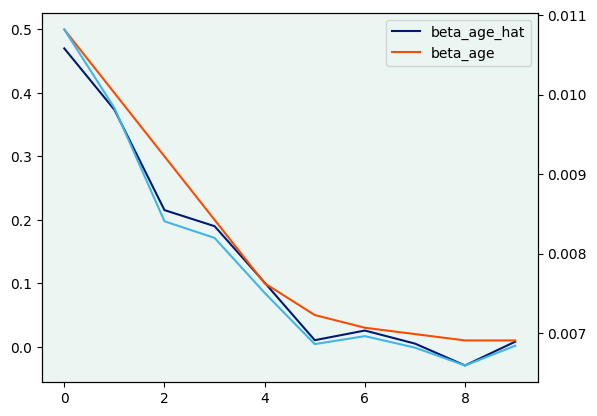

In [82]:
ax = pd.DataFrame(nc_trace["α"]).mean().plot(label = "beta_age_hat")
pd.Series(beta_age).plot(label = "beta_age", ax = ax)
ax.legend()
tax = ax.twinx()
yob.groupby("age")["default"].mean().plot(ax = tax, color = palette[2])

<Axes: xlabel='age'>

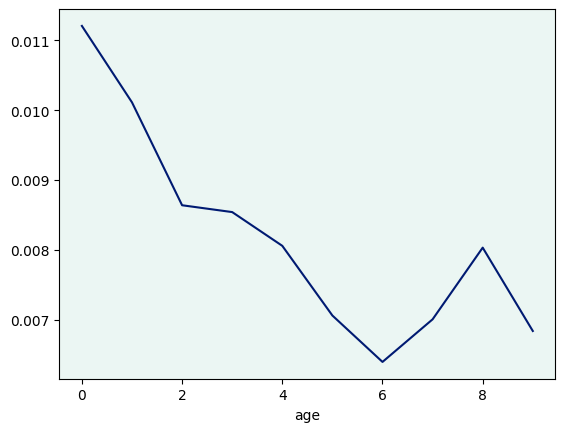

In [62]:
yob.groupby("age")["default"].mean().plot()

In [61]:
nc_trace["η0"].mean()

-4.0089705219474405

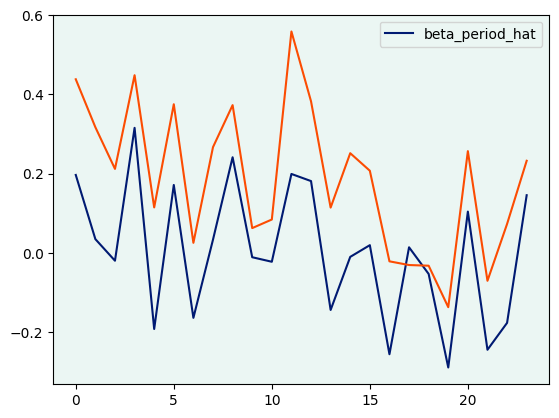

In [69]:
pd.DataFrame(nc_trace["γ"]).mean().plot(label = "beta_period_hat")
plt.plot(df.market_effect.values*beta_cohort)
plt.legend()

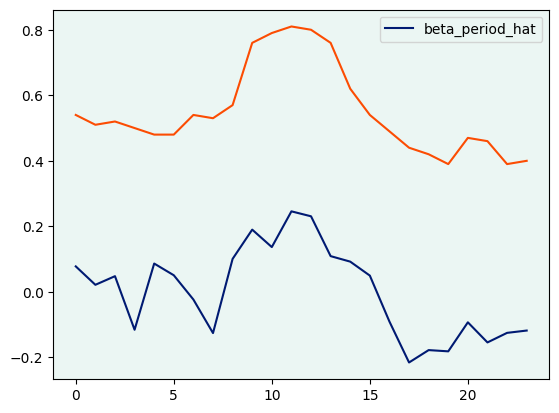

In [70]:
pd.DataFrame(nc_trace["β"]).mean().plot(label = "beta_period_hat")
plt.plot(df.unemp.values*beta_period)
plt.legend()

In [53]:
def noncentered_normal_rw(name, *, dims):    
    innov = pm.Normal(f"innov_{name}", 0, 1, dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)
    
    return pm.Deterministic(name, innov.cumsum() * σ, dims=dims)



with pm.Model(coords=coords) as rw_model:
    # η0 = pm.Normal("η0", 0, 2.5)
    η0 = pm.Normal("η0", 0, -5.01)    
    α = noncentered_normal_rw("α", dims="age")
    β = noncentered_normal_rw("β", dims="period")
    γ = noncentered_normal_rw("γ", dims="cohort")

with rw_model:
    η = η0 + α[i] + β[j] + γ[k]
    
    p = pm.math.invlogit(η)
    # pm.HalfNormal("ν", 2.5)
    # pm.Binomial("default", N, p, observed=defaults)
    pm.Binomial("default", N, p, observed=defaults)

In [54]:


with rw_model:
    rw_trace = pm.sample(target_accept=0.95, **SAMPLE_KWARGS)



SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'η0': array(0.), 'innov_α': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'σ_α_log__': array(1.19665215), 'innov_β': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), 'σ_β_log__': array(1.19665215), 'innov_γ': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), 'σ_γ_log__': array(1.19665215)}

Initial evaluation results:
η0                -inf
innov_α          -9.19
σ_α_log__        -0.77
innov_β         -22.05
σ_β_log__        -0.77
innov_γ         -22.05
σ_γ_log__        -0.77
default     -121588.54
Name: Log-probability of test_point, dtype: float64

Got error No model on context stack. trying to find log_likelihood in translation.
/home/lsio/.cache/pypoetry/virtualenvs/notebooks-5GmdqOuk-py3.10/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


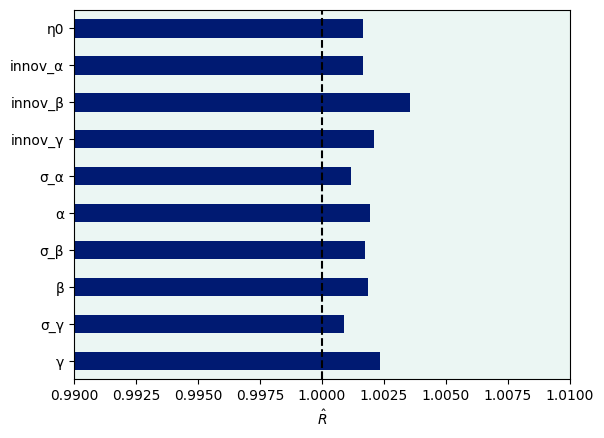

In [72]:
rw_rhat = az.rhat(rw_trace)

ax = (rw_rhat.max()
             .to_array()
             .to_series()
             .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.01);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

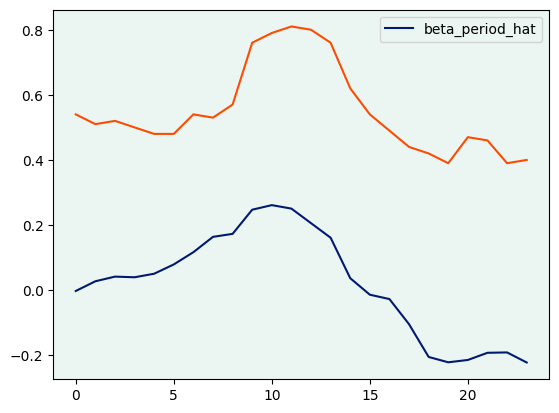

In [75]:
pd.DataFrame(rw_trace["β"]).mean().plot(label = "beta_period_hat")
plt.plot(df.economic_stress.values)
plt.legend()

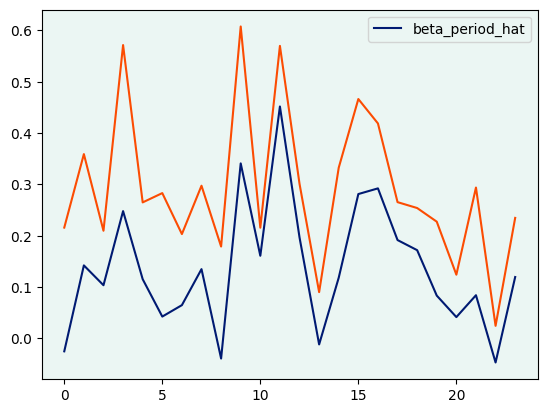

In [78]:
pd.DataFrame(rw_trace["γ"]).mean().plot(label = "beta_period_hat")
plt.plot(df.market_effect.values)
plt.legend()

In [29]:
with nc_model:
    ppr = pm.sample_posterior_predictive(nc_trace)

In [31]:
apc_df

size  sum
age period cohort           
0   2000   2000     100    4
    2001   2001     100    3
    2002   2002     100    0
    2003   2003     100    2
    2004   2004     100    4
...                 ...  ...
9   2019   2010      85    0
    2020   2011      78    2
    2021   2012      75    3
    2022   2013      85    0
    2023   2014      87    1

[195 rows x 2 columns]

In [54]:
default_by_age = pd.DataFrame(ppr["default"]).T.mean(axis = 1).reset_index()
default_by_age["age"] = apc_df.index.get_level_values("age").values

<Axes: xlabel='age'>

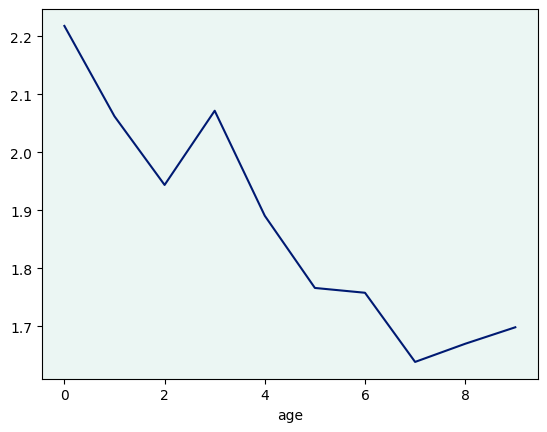

In [41]:
default_by_age[default_by_age.age == 0].quantile(0.05)

0       0.00
1       0.15
2       0.00
3       0.00
4       0.00
        ... 
5996    0.00
5997    0.15
5998    0.00
5999    1.00
age     0.00
Name: 0.05, Length: 6001, dtype: float64

In [65]:
beta_age

[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02, 0.01, 0.01]

<Axes: xlabel='age'>

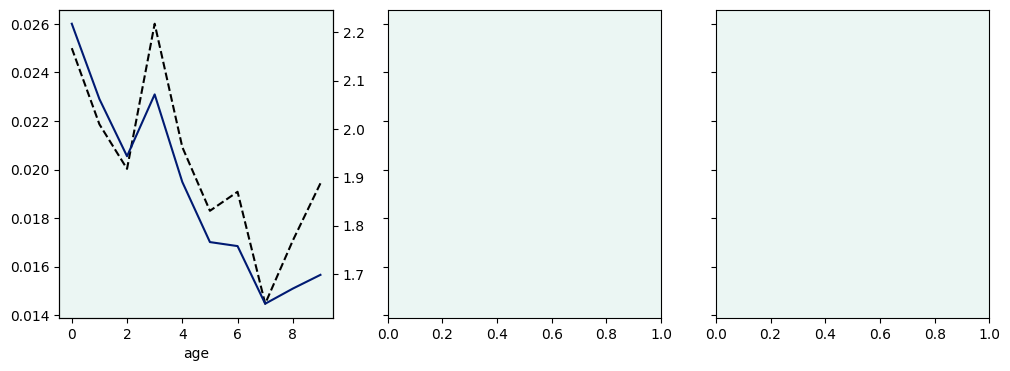

In [63]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

(yob.groupby("age")
        ["default"]
        .mean()
        .plot(c="k", ls="--", label="Observed", ax=axs[0]))

tax = axs[0].twinx()
default_by_age.groupby("age")[0].mean().plot(ax = tax)


In [71]:
defaults

array([5, 5, 4, 2, 5, 0, 4, 0, 1, 3, 2, 6, 7, 2, 4, 0, 2, 2, 5, 3, 2, 3,
       1, 1, 3, 0, 2, 1, 1, 2, 3, 1, 4, 2, 2, 6, 3, 2, 1, 2, 7, 0, 0, 0,
       2, 4, 4, 0, 0, 0, 4, 2, 1, 1, 1, 2, 0, 3, 3, 0, 2, 1, 1, 0, 2, 1,
       2, 0, 3, 4, 1, 3, 1, 3, 2, 4, 4, 2, 4, 4, 1, 0, 1, 1, 1, 3, 0, 1,
       1, 3, 3, 3, 2, 0, 2, 0, 2, 4, 1, 4, 6, 4, 2, 1, 2, 3, 0, 2, 1, 1,
       1, 0, 0, 2, 2, 0, 1, 0, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 4, 1, 1, 0,
       5, 6, 3, 3, 1, 2, 1, 2, 1, 1, 0, 2, 1, 1, 1, 0, 3, 3, 2, 2, 2, 3,
       2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0, 4, 1, 4, 0, 0, 0, 1,
       1, 0, 1, 1, 2, 4, 0, 1, 4, 1, 2, 1, 3, 2, 2, 2, 1, 1, 2])

In [69]:
ppr["default"].mean(axis = 0)

array([3.1125    , 3.05383333, 2.26216667, 2.6765    , 2.96633333,
       2.52166667, 2.74033333, 2.13483333, 2.34666667, 3.1605    ,
       3.30533333, 3.19416667, 3.18116667, 3.17083333, 2.8005    ,
       2.38266667, 2.34      , 2.43183333, 2.34016667, 2.4065    ,
       2.1525    , 2.52033333, 2.2675    , 2.72983333, 2.5285    ,
       1.9625    , 2.02766667, 2.18966667, 2.42883333, 2.00433333,
       1.88983333, 2.00133333, 2.55433333, 2.455     , 2.51916667,
       2.83033333, 2.6595    , 2.14466667, 2.03      , 1.79183333,
       2.18466667, 1.76083333, 2.07416667, 1.67783333, 1.905     ,
       1.9655    , 2.3895    , 1.36316667, 1.48866667, 1.354     ,
       1.54483333, 1.56766667, 1.16583333, 1.436     , 1.82716667,
       1.62833333, 1.548     , 1.98766667, 2.0525    , 1.47033333,
       1.27666667, 1.24766667, 1.3755    , 1.211     , 1.343     ,
       1.18316667, 1.24366667, 1.21933333, 1.70683333, 2.0135    ,
       2.05416667, 1.9225    , 1.94083333, 1.834     , 1.81583

In [61]:
with nc_model:
    pm.set_data({"default": np.full_like(N, N_PP)})
    nc_trace.extend(pm.sample_posterior_predictive(nc_trace))

TypeError: The variable `default` must be defined as `pymc3.Data` inside the model to allow updating. The current type is: <class 'pymc3.model.ObservedRV'>.